#### Created By: 
Iman sharifi --- 98210184

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read images
img1_ = cv2.imread('HW4\\3-1.jpeg')
img2_ = cv2.imread('HW4\\3-2.jpeg')

In [3]:
def _plot(img, title='image', figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(img), plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

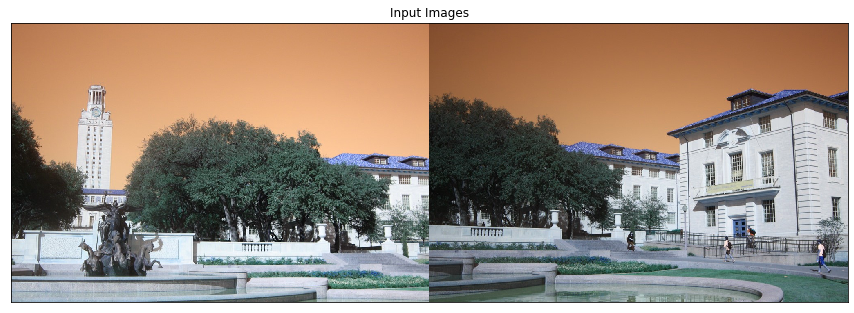

In [4]:
# Cancatenate Images
plt_img = np.concatenate((img1_, img2_), axis=1)
_plot(plt_img,'Input Images',(15,15))

### Matching

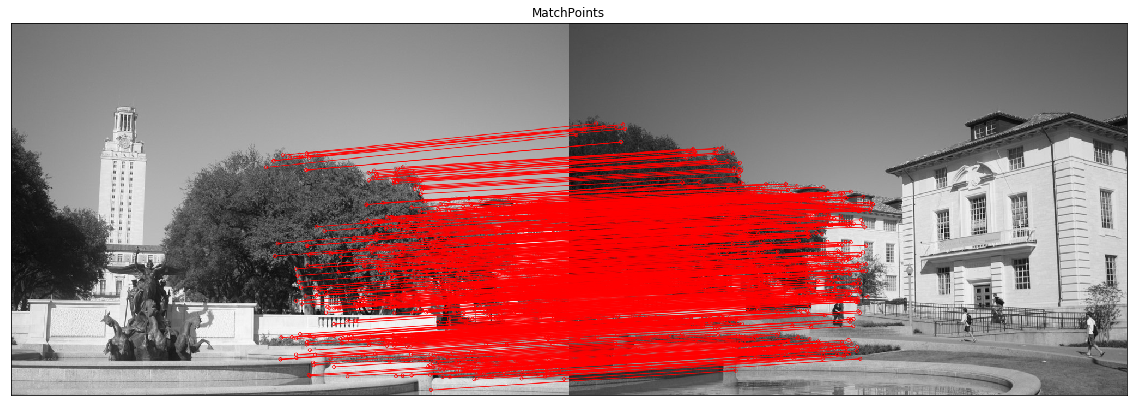

In [5]:
MIN_MATCH_COUNT = 10
img1 = cv2.cvtColor(img1_, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_, cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Method used to computed a homography matrix. The following methods are possible: #0 - a regular method using all the points
    # CV_RANSAC - RANSAC-based robust method
    # CV_LMEDS - Least-Median robust method

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape

    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

#     img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None


draw_params = dict(matchColor=(255, 0, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
_plot(img3, 'MatchPoints', (20, 20))

# Panorama Image

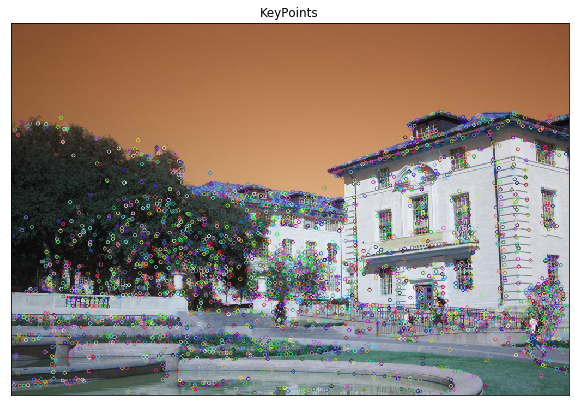

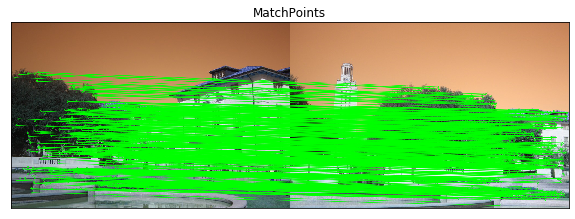

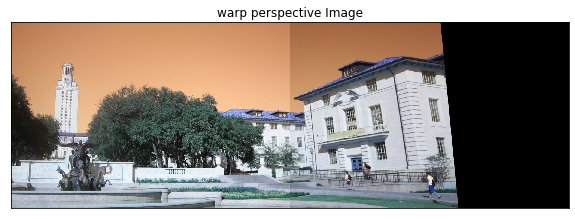

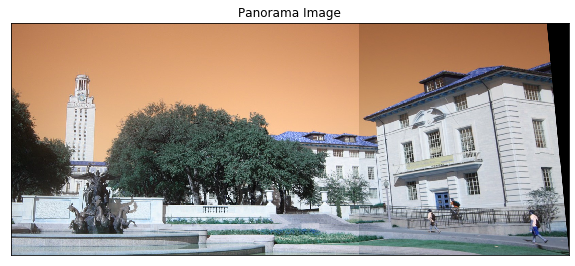

In [9]:
# RGB to Gray
img_ = img2_
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)

img = img1_
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Create SIFT 
sift = cv2.xfeatures2d.SIFT_create()

# find key points
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

_plot(cv2.drawKeypoints(img_,kp1,None), 'KeyPoints')

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(img_,kp1,img,kp2,good,None,**draw_params)
_plot(img3, 'MatchPoints')

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    #cv2.imshow("original_image_overlapping.jpg", img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

dst = cv2.warpPerspective(img_,M,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0],0:img.shape[1]] = img

_plot(dst,'warp perspective Image')

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

_plot(trim(dst), 'Panorama Image')
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))